WILL THEORY: RELATIONAL INERTIA TEST
Hubble Parameter (H0): 68.1 km/s/Mpc
Critical Acceleration (a_Mach): 7.020e-11 m/s²
Speed of Light: 2.998e+08 m/s

Total data points loaded: 3391
Data points after filtering: 3350

STATISTICAL ANALYSIS (Log-space metrics)

WILL Theory Performance:
  RMSE (log-space):           0.0545 dex
  MAE (log-space):            0.0434 dex
  Bias (log-space):           +0.0146 dex
  Mean Relative Error:        9.70%
  Number of bins analyzed:    19

Interpretation:
  ✓ EXCELLENT fit (RMSE < 0.1 dex)
  ✓ Negligible systematic bias

SAMPLE DATA POINTS
r/R_bubble   Data         WILL         Error %   
------------------------------------------------------------
      0.146        1.296        1.146      11.63%
      0.362        1.111        1.362      22.58%
      1.128        2.085        2.128       2.04%
      3.516        4.831        4.516       6.53%
      8.731       13.650        9.731      28.71%



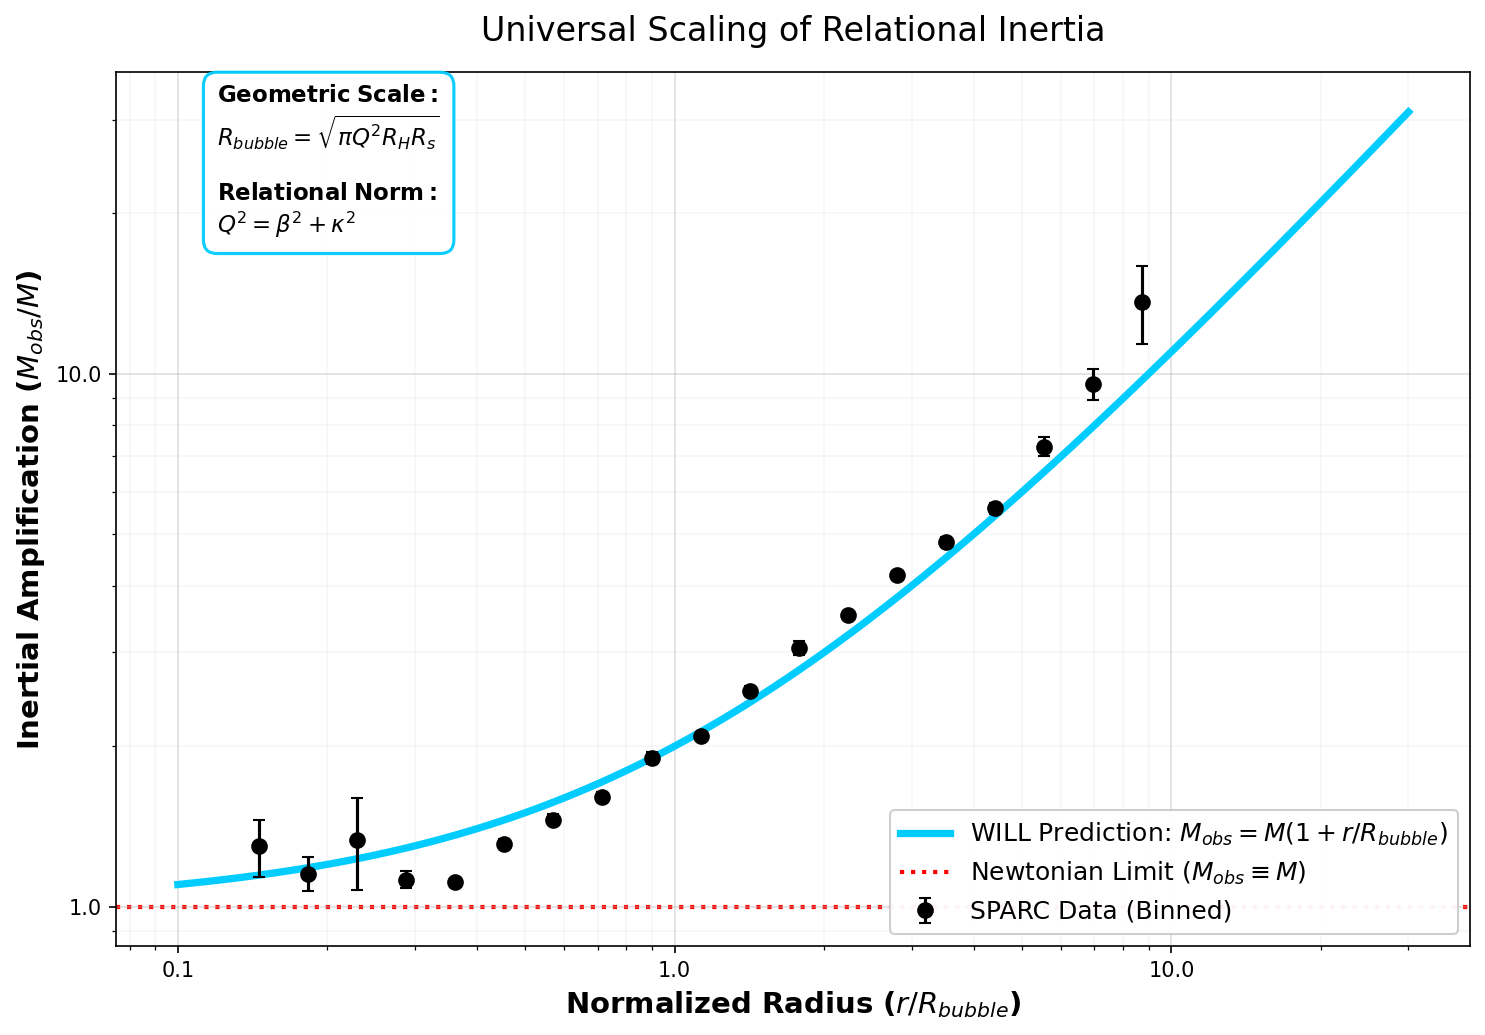

Analysis complete. Graph displayed.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==========================================
# WILL RG: FINAL PLOT - RELATIONAL SHIFT Q
# ==========================================

# 1. CONSTANTS
H0_VAL = 68.1
MPC_M = 3.08567758e22
H0_SI = (H0_VAL * 1000) / MPC_M
C_SI = 299792458
G = 6.6743e-11
# a_Mach derived from H0
A_MACH = (C_SI * H0_SI) / (3 * np.pi)

print("=" * 60)
print("WILL THEORY: RELATIONAL INERTIA TEST")
print("=" * 60)
print(f"Hubble Parameter (H0): {H0_VAL} km/s/Mpc")
print(f"Critical Acceleration (a_Mach): {A_MACH:.3e} m/s²")
print(f"Speed of Light: {C_SI:.3e} m/s")
print("=" * 60 + "\n")

# 2. DATA LOADING (SPARC)
URL_SPARC = "https://cdsarc.cds.unistra.fr/ftp/J/AJ/152/157/table2.dat"
KPC_IN_M = 3.086e19

def get_clean_data():
    cols = [(0, 11), (19, 25), (26, 32), (33, 38), (39, 45), (46, 52), (53, 59)]
    names = ['Name', 'Rad', 'Vobs', 'e_Vobs', 'Vgas', 'Vdisk', 'Vbul']
    try:
        df = pd.read_fwf(URL_SPARC, colspecs=cols, header=None, names=names, comment='#')
        for c in names[1:]: df[c] = pd.to_numeric(df[c], errors='coerce')
        df = df.dropna()
        df = df[ (df['Rad']>0) & (df['Vobs']>0) ]

        # --- NEW ONTOLOGY ---
        # 1. Source Mass (M) - The gravitational anchor
        v_source_sq = (df['Vgas']*1000)**2 + 0.5*(df['Vdisk']*1000)**2 + 0.7*(df['Vbul']*1000)**2
        v_source_sq = np.maximum(v_source_sq, 10.0)
        r_m = df['Rad'] * KPC_IN_M

        m_source = (v_source_sq * r_m) / G

        # 2. Observed Inertia (M_obs) - The total measured response
        m_obs = ((df['Vobs']*1000)**2 * r_m) / G

        # 3. Inertial Amplification Factor (Y-axis)
        y_factor = m_obs / m_source

        # 4. Bubble Radius (R_bubble)
        r_bubble = np.sqrt( (G * m_source) / A_MACH )

        # 5. Normalized Radius (X-axis)
        x_scale = r_m / r_bubble

        return x_scale, y_factor
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# 3. DATA ANALYSIS
x_data, y_data = get_clean_data()

if x_data is not None:
    print(f"Total data points loaded: {len(x_data)}")

    # Filter for clean visualization range
    mask = (x_data > 0.1) & (x_data < 30) & (y_data > 0.5) & (y_data < 200)
    x_clean = x_data[mask]
    y_clean = y_data[mask]

    print(f"Data points after filtering: {len(x_clean)}\n")

    # Binning Data
    bins = np.logspace(np.log10(x_clean.min()), np.log10(x_clean.max()), 22)
    bin_centers, bin_means, bin_errs = [], [], []
    for i in range(len(bins)-1):
        b_mask = (x_clean >= bins[i]) & (x_clean < bins[i+1])
        if np.sum(b_mask) > 10:
            bin_centers.append(np.sqrt(bins[i]*bins[i+1]))
            bin_means.append(np.mean(y_clean[b_mask]))
            bin_errs.append(np.std(y_clean[b_mask]) / np.sqrt(np.sum(b_mask)))

    bin_centers = np.array(bin_centers)
    bin_means = np.array(bin_means)
    bin_errs = np.array(bin_errs)

    # === NUMERICAL RESULTS ===
    print("=" * 60)
    print("STATISTICAL ANALYSIS (Log-space metrics)")
    print("=" * 60)

    # WILL Theory Prediction: M_obs/M = 1 + r/R_bubble
    y_pred_will = 1 + bin_centers

    # Convert to log space for proper error calculation
    log_data = np.log10(bin_means)
    log_pred = np.log10(y_pred_will)

    # Metrics
    rmse = np.sqrt(mean_squared_error(log_data, log_pred))
    mae = mean_absolute_error(log_data, log_pred)
    bias = np.mean(log_data - log_pred)

    # Relative accuracy (percentage)
    relative_error = np.abs((bin_means - y_pred_will) / bin_means) * 100
    mean_relative_error = np.mean(relative_error)

    print(f"\nWILL Theory Performance:")
    print(f"  RMSE (log-space):           {rmse:.4f} dex")
    print(f"  MAE (log-space):            {mae:.4f} dex")
    print(f"  Bias (log-space):           {bias:+.4f} dex")
    print(f"  Mean Relative Error:        {mean_relative_error:.2f}%")
    print(f"  Number of bins analyzed:    {len(bin_centers)}")

    print(f"\nInterpretation:")
    if rmse < 0.1:
        print(f"  ✓ EXCELLENT fit (RMSE < 0.1 dex)")
    elif rmse < 0.2:
        print(f"  ✓ GOOD fit (RMSE < 0.2 dex)")
    else:
        print(f"  ⚠ Moderate fit (RMSE = {rmse:.3f} dex)")

    if abs(bias) < 0.05:
        print(f"  ✓ Negligible systematic bias")
    else:
        direction = "overestimates" if bias < 0 else "underestimates"
        print(f"  ⚠ Theory {direction} by {abs(bias):.3f} dex")

    print("\n" + "=" * 60)
    print("SAMPLE DATA POINTS")
    print("=" * 60)
    print(f"{'r/R_bubble':<12} {'Data':<12} {'WILL':<12} {'Error %':<10}")
    print("-" * 60)
    for i in [0, len(bin_centers)//4, len(bin_centers)//2, 3*len(bin_centers)//4, -1]:
        err_pct = relative_error[i]
        print(f"{bin_centers[i]:11.3f}  {bin_means[i]:11.3f}  {y_pred_will[i]:11.3f}  {err_pct:9.2f}%")
    print("=" * 60 + "\n")

    # === PLOTTING ===
    fig, ax = plt.subplots(figsize=(10, 7), dpi=150)

    # THEORY LINE (Cyan) - Pure Linear Scaling
    x_theory = np.logspace(np.log10(0.1), np.log10(30), 100)
    ax.plot(x_theory, 1 + x_theory, color='#00CCFF', linewidth=3.5, zorder=2,
            label=r'WILL Prediction: $M_{obs} = M (1 + r/R_{bubble})$')

    # NEWTONIAN BASELINE (Red Dotted)
    ax.axhline(1.0, color='red', linestyle=':', linewidth=2, zorder=1,
               label=r'Newtonian Limit ($M_{obs} \equiv M$)')

    # DATA POINTS (Black)
    ax.errorbar(bin_centers, bin_means, yerr=bin_errs, fmt='o', color='black',
                ecolor='black', capsize=3, markersize=7, zorder=3,
                label='SPARC Data (Binned)')

    # SCALES & LABELS
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Normalized Radius ($r / R_{bubble}$)', fontsize=14, fontweight='bold')
    ax.set_ylabel(r'Inertial Amplification ($M_{obs} / M$)', fontsize=14, fontweight='bold')

    # Title
    ax.set_title(r'Universal Scaling of Relational Inertia', fontsize=16, pad=15)

    # ANNOTATION: The Geometric Origin (Only Q² = β² + κ²)
    formula_text = (r"$\mathbf{Geometric\;Scale:}$" + "\n" +
                    r"$R_{bubble} = \sqrt{\pi Q^2 R_H R_s}$" + "\n\n" +
                    r"$\mathbf{Relational\;Norm:}$" + "\n" +
                    r"$Q^2 = \beta^2 + \kappa^2$")

    ax.text(0.12, 35, formula_text, fontsize=11, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.95, edgecolor='#00CCFF', linewidth=1.5, boxstyle='round,pad=0.6'))

    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

    ax.grid(True, which='major', alpha=0.4)
    ax.grid(True, which='minor', alpha=0.1)

    ax.legend(fontsize=12, loc='lower right', framealpha=0.95)

    plt.tight_layout()
    plt.show()

    print("Analysis complete. Graph displayed.")
else:
    print("Failed to load data.")